In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
import joblib

df = pd.read_csv('bank-additional-full.csv', sep=";")
df.replace('unknown', np.nan, inplace=True)
# Remove duration column because this higly affect predictions
df = df.drop('duration', axis=1)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [11]:
# Check missing values
import warnings
warnings.filterwarnings("ignore")
df.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

# A. Preprocess the dataset

In [12]:
# define the featuers
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                        'contact', 'month', 'day_of_week', 'poutcome']
numerical_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                      'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

### a. Handle outliners

before Shape: (41188, 20)
after Shape: (36592, 20)


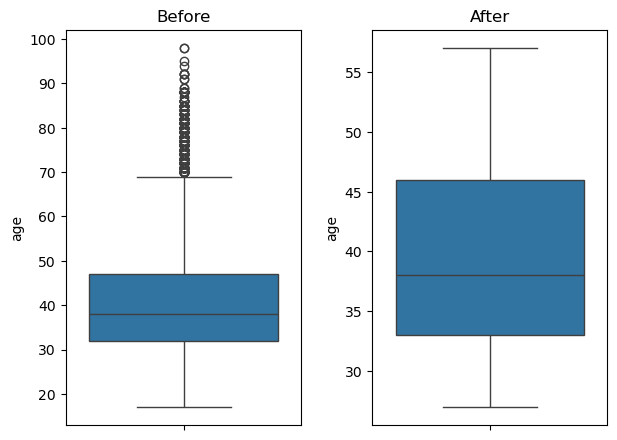

In [13]:
fig, axes = plt.subplots(1, 2)
plt.tight_layout(pad=2.0)

print("before Shape:", df.shape)

max_val = df.age.quantile(0.95)
min_val = df.age.quantile(0.05)

df2 = df[(df['age'] > min_val) & (df['age'] < max_val)].copy()
print("after Shape:", df2.shape)

sns.boxplot(df['age'], orient='v', ax=axes[0])
axes[0].set_title('Before')
sns.boxplot(df2['age'], orient='v', ax=axes[1])
axes[1].set_title('After')
df = df2
plt.show()

### a. Handle Missing Values

In [14]:
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

### b. Handle encoding for categorical features

In [15]:

cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df['y'] = df['y'].map({'no':0, 'yes':1})

### c. Scale / standarized the numberical features

In [16]:

num_scaler = StandardScaler()
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


#### Data mining process with pipeline (missing values, encoding, scaling)

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', num_imputer),
            ('scaler', num_scaler)
        ]), numerical_features),
        
        ('cat', Pipeline(steps=[
            ('imputer', cat_imputer),
            ('encoder', cat_encoder)
        ]), categorical_features)
    ])


# Separate input (X) and output (y)
X = df.drop(columns=['y'])
y = df['y']

df_before = df
# Fit and transform data
X_transformed = preprocessor.fit_transform(X)
df_transformed = pd.DataFrame(X_transformed, columns=numerical_features + categorical_features)
joblib.dump(preprocessor, "preprocessor.joblib")

df_transformed['y'] = y.values
df = df_transformed

df.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,1.990074,-0.56611,0.173556,-0.336414,0.611237,0.720994,0.940386,0.671759,0.275371,3.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0,0
1,2.111434,-0.56611,0.173556,-0.336414,0.611237,0.720994,0.940386,0.671759,0.275371,7.0,1.0,3.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0,0
2,-0.315764,-0.56611,0.173556,-0.336414,0.611237,0.720994,0.940386,0.671759,0.275371,7.0,1.0,3.0,0.0,1.0,0.0,1.0,6.0,1.0,1.0,0
3,0.048316,-0.56611,0.173556,-0.336414,0.611237,0.720994,0.940386,0.671759,0.275371,0.0,1.0,1.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0,0
4,1.990074,-0.56611,0.173556,-0.336414,0.611237,0.720994,0.940386,0.671759,0.275371,7.0,1.0,3.0,0.0,0.0,1.0,1.0,6.0,1.0,1.0,0


In [18]:

# check null values
df.isnull().sum()

age               0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
poutcome          0
y                 0
dtype: int64

### c. Showing graphs for scaling before and after

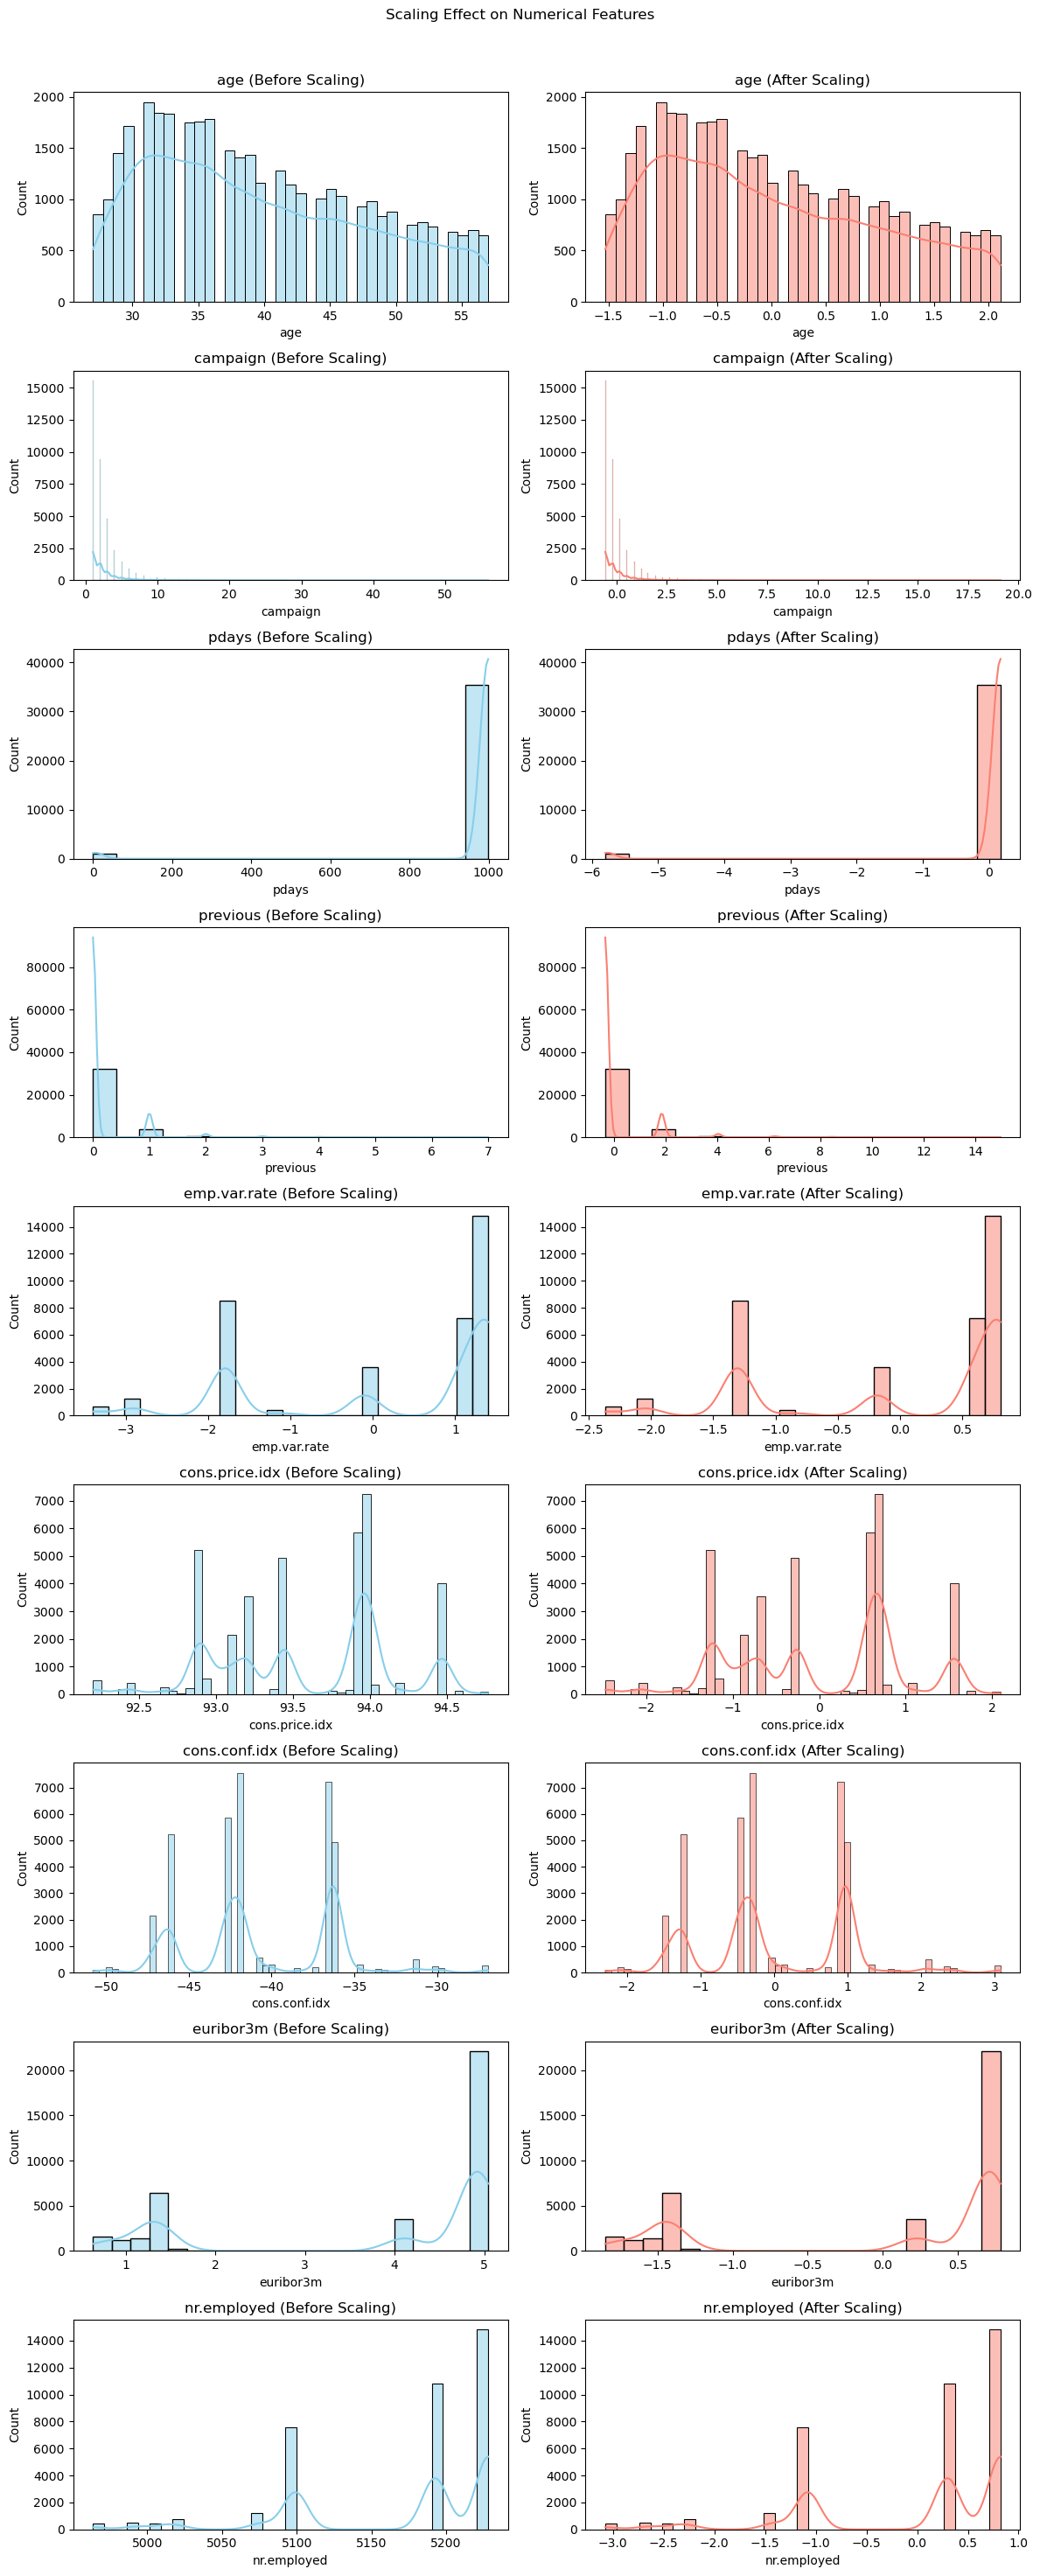

In [19]:
# Plot histograms before and after scaling
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 30))
fig.suptitle("Scaling Effect on Numerical Features", fontsize=12)

for i, col in enumerate(numerical_features):
    # Original
    sns.histplot(df_before[col], ax=axes[i, 0], kde=True, color='skyblue')
    axes[i, 0].set_title(f"{col} (Before Scaling)")
    
    # Scaled
    sns.histplot(df[col], ax=axes[i, 1], kde=True, color='salmon')
    axes[i, 1].set_title(f"{col} (After Scaling)")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# Log transform skewed features

In [20]:
# skewed_features = ['campaign', 'pdays', 'previous']
# for feature in skewed_features:
#     df[feature] = np.log1p(df[feature])

# Check by Q=Q Plot again

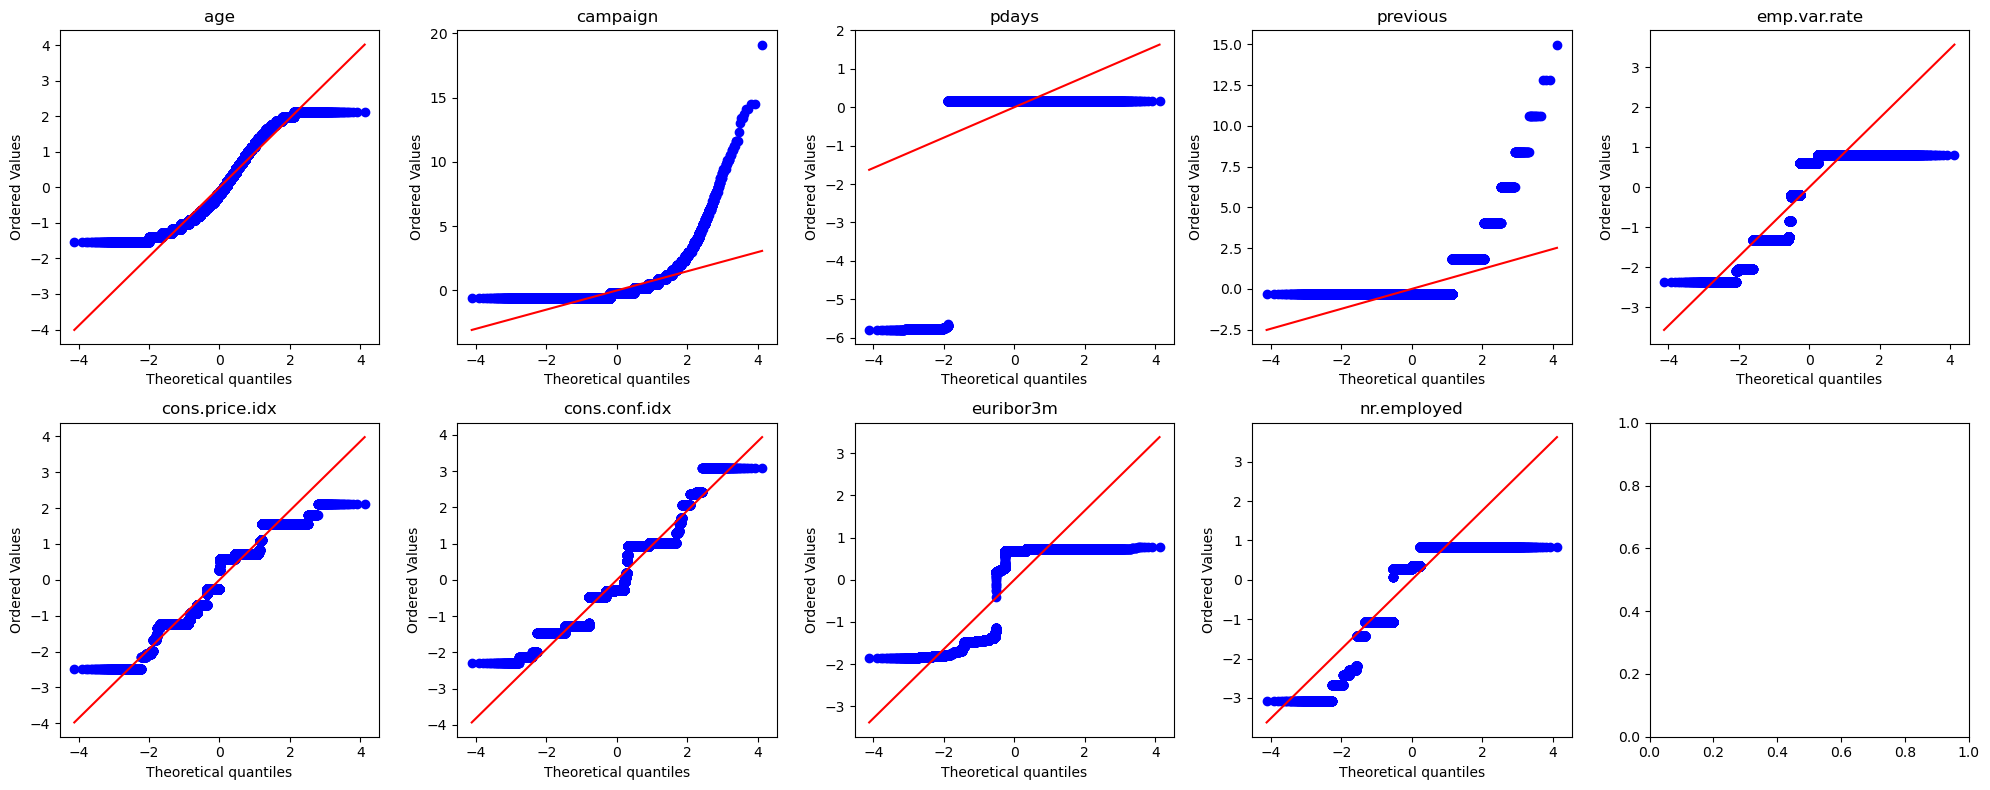

In [21]:
import scipy.stats as stats
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, feature in enumerate(numerical_features):
    row, col = i // 5, i % 5
    stats.probplot(df[feature], dist="norm", plot=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

# Check by Hist Plot

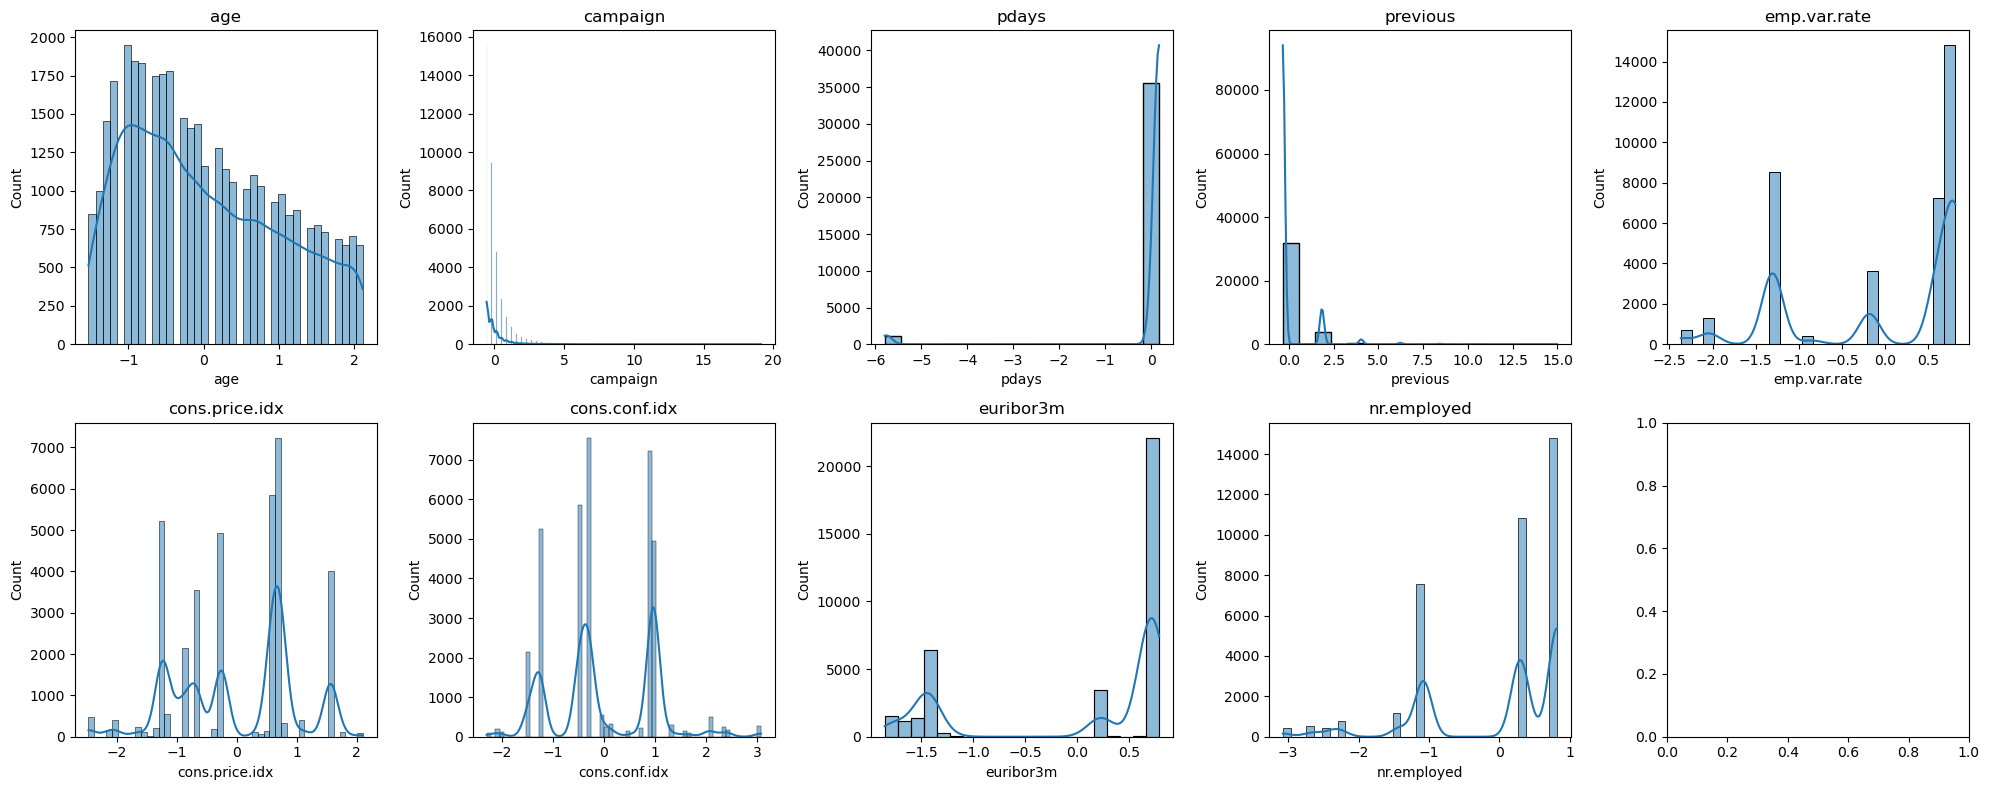

In [22]:
import seaborn as sns

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, feature in enumerate(numerical_features):
    row, col = i // 5, i % 5
    sns.histplot(df[feature], kde=True, ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

# Logarith Transformer

In [23]:
# from sklearn.preprocessing import FunctionTransformer

# data = df.replace(0, np.nan)
# df_clean = data.dropna()

# # Apply log transformation only to skewed features
# logarithm_transformer = FunctionTransformer(np.log, validate=True)
# df_clean[skewed_features] = logarithm_transformer.transform(df_clean[skewed_features])

# df = df_clean.copy()

# df.head()

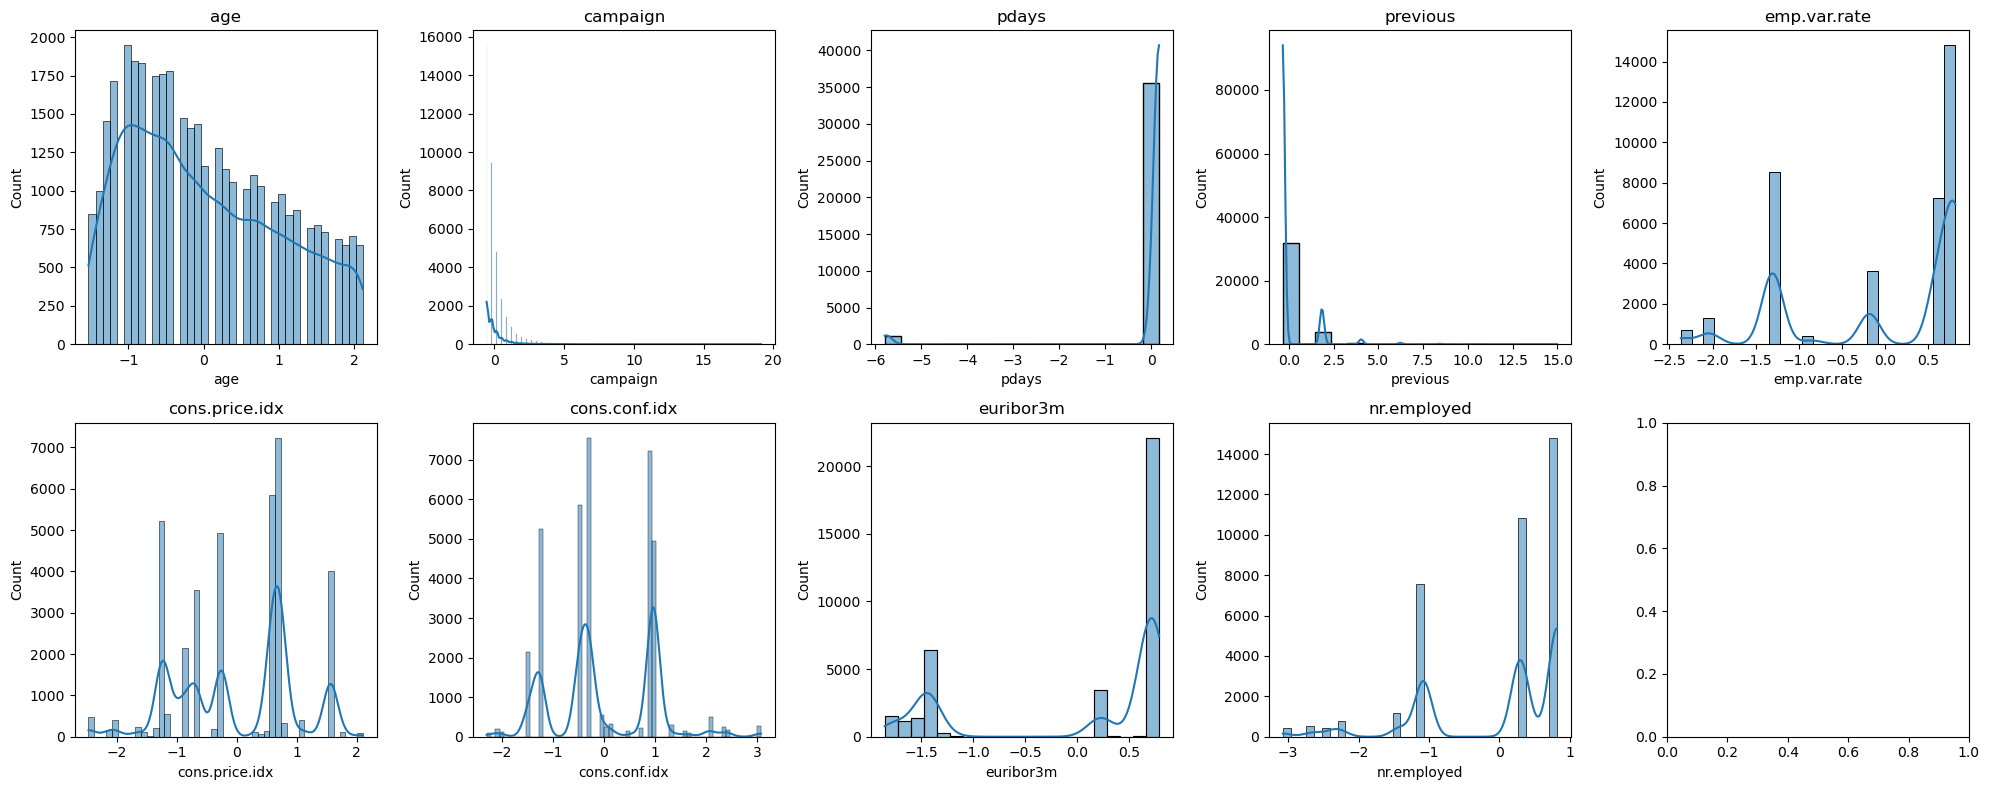

In [24]:
import seaborn as sns

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, feature in enumerate(numerical_features):
    row, col = i // 5, i % 5
    sns.histplot(df[feature], kde=True, ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

# Split Data into Training & Testing Sets

In [25]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['y'])  # Input features
y = df['y']  # Output

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)

X_train Shape: (29273, 19)
X_test Shape: (7319, 19)


# Train & Test Models
### (a) Train Support Vector Machine (SVM)

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)  # Train the model
svm_pred = svm_model.predict(X_test)  # Make predictions

# Evaluate SVM
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM Classification Report:\n", classification_report(y_test, svm_pred))

SVM Accuracy: 0.9061347178576308
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      6592
           1       0.59      0.17      0.27       727

    accuracy                           0.91      7319
   macro avg       0.75      0.58      0.61      7319
weighted avg       0.88      0.91      0.88      7319



### (b) Train Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)  # Train the model
lr_pred = lr_model.predict(X_test)  # Make predictions

# Evaluate Logistic Regression
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_pred))

Logistic Regression Accuracy: 0.9098237464134444
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      6592
           1       0.68      0.18      0.28       727

    accuracy                           0.91      7319
   macro avg       0.80      0.58      0.62      7319
weighted avg       0.89      0.91      0.89      7319



# Persiting Models


In [28]:
import joblib

joblib.dump(svm_model, 'svm_model.joblib')
joblib.dump(lr_model, 'lr_model.joblib')

# test models
preprocessor = joblib.load("preprocessor.joblib")
svm_model = joblib.load('svm_model.joblib')
lr_model = joblib.load('lr_model.joblib')

# test example
manual_input = pd.DataFrame([{
    'age': 49, 'campaign': 1, 'pdays': 999, 'previous': 0,
    'emp.var.rate': 1.1, 'cons.price.idx': 93.994, 'cons.conf.idx': -36.4,
    'euribor3m': 4.857, 'nr.employed': 5191.0,
    'job': 'technician.', 'marital': 'married', 'education': 'basic.9y', 'default': 'no',
    'housing': 'no', 'loan': 'no', 'contact': 'telephone', 'month': 'may',
    'day_of_week': 'mon', 'poutcome': 'nonexistent'
}])

manual_transformed = preprocessor.transform(manual_input)
prediction = lr_model.predict(manual_transformed)

print("Manual Input Prediction:", prediction)
pd.DataFrame(manual_transformed, columns=numerical_features + categorical_features).head(1)

Manual Input Prediction: [0]


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,1.140555,-0.56611,0.173556,-0.336414,0.611237,0.720994,0.940386,0.671759,0.275371,-1.0,1.0,2.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0


In [29]:
import sklearn
print(sklearn.__version__)

1.5.1
